In [1]:
#These are the necessary libraries for the rental property project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.feature_selection import chi2
import requests
from bs4 import BeautifulSoup
import statistics as stats


In [2]:
#These variables are for the city and state for rent location
userCity = input('Enter a USA City: ')
state = input('Enter a USA State Abbreviation:  ')
stateName = input('Enter a USA State: ')
city = ''
city2 = ''

#This generator goes through every character in the city string
def Generator(cityName):
    for letter in range(0,len(cityName),1):
        yield(cityName[letter])

#goes through every character in the generator object and parses like we want
cityIterator = Generator(userCity)
for letter in cityIterator:
    if(letter == ' '):
        city = city + '-'
    else:
        city = city + letter
        
print(city)
print(state)

Enter a USA City: raleigh
Enter a USA State Abbreviation:  nc
Enter a USA State: north carolina
raleigh
nc


In [3]:
#This lambda function skips over the first integer of an iterable object    
skipFirst = lambda x: x[1:] 

#This class cleans and parses data
class dataParser():
    def __init__(self,data):
        self.array = data
        self.int = data
        self.string = data
        
        self.newString = ''
        self.emptyArray = []
        
    def floatOperations(self):
        pass
        
    def stringOperations(self):
        
        #Sees if the string is '--' to make it to nan onject
        if(skipFirst(self.string) == '--') or (self.string == '--'):
            self.newString = np.nan
            
        #Does a different transformation if the string appears tp be a number    
        else:
            #Transforms if it's a rental price
            if(self.string[0] == '$'):
                self.string = Generator(skipFirst(self.string))
                for char in self.string:
                    if((char == '/') or (char == '+')):
                        break
                    elif(char == ','):
                        pass
                    else:
                        self.newString = self.newString + char
            else:
                pass
                
        return float(self.newString)
    
#This function work with arrays, specially with beds, bath, & area
def generalCleaner(array):
    newArray = []
    array = Generator(array)

    for variable in array:
        newString = ''
        if(('--' in variable) or ('Studio' in variable)):
            newArray.append(np.nan)
        else:
            variable = Generator(variable)
            for char in variable:
                if((char == ' ') or (char == ',')):
                    pass
                elif(char.isnumeric() == False):
                    break
                else:
                    newString = newString + char

            newArray.append(int(newString))

    return newArray


In [4]:
#Requests website that has the data for beds, baths, square feet, &/or zip/address code of the rental property's 1st page
realtorWebsiteSource = requests.get(f'https://www.homes.com/{city}-{state}/homes-for-rent/').text
realtorWebsiteSoup = BeautifulSoup(realtorWebsiteSource,'lxml')

#This for loop gets the last web page of available rentals, so we can loop over them
for page in realtorWebsiteSoup.find_all('a',class_ = 'flex items-center justify-center radius-5 border-1 border-gray-lighter bngq86v mx-1/2 no-underline'):
    test = page.text
    lastPage = test

#These are empty lists 
genData = []
prices = []
zipCodes = []
baths = []
beds = []
area = []

#These loops get us the zip codes, and rental prices
for number in range(1,int(lastPage)+1,1):
    if(number == 1):
        
        #This for loop gets the 1st page's prices
        for data in realtorWebsiteSoup.find_all('div',class_ = 'flex items-center mb-1/2'):
            price = data.text
            prices.append(price)
            
        #This for loop gets the 1st page's zip codes
        for data in realtorWebsiteSoup.find_all('h2',class_ = 'a16jsq91 font-size-s font-weight-regular truncate'):
            zipCode = data.text
            zipCodes.append(zipCode[-5:])
            
        for data in realtorWebsiteSoup.find_all('div',class_ = 'mb-1/2 font-size-m'):
            test = data.text
            genData.append(test)
            
    else:
        
        #This for loop gets data for the 2nd webpage and above
        realtorWebsiteSource = requests.get(f'https://www.homes.com/{city}-{state}/homes-for-rent/p{number}/').text
        realtorWebsiteSoup = BeautifulSoup(realtorWebsiteSource,'lxml')
        
        #This for loop gets the 2nd+ page's prices
        for data in realtorWebsiteSoup.find_all('div',class_ = 'flex items-center mb-1/2'):
            price = data.text
            prices.append(price)
        
        #This for loop gets the 2nd+ page's zip codes
        for data in realtorWebsiteSoup.find_all('h2',class_ = 'a16jsq91 font-size-s font-weight-regular truncate'):
            zipCode = data.text
            zipCodes.append(zipCode[-5:])
            
        #These for loops separate the data for: Beds, Baths, & Space
        for data in realtorWebsiteSoup.find_all('div',class_ = 'mb-1/2 font-size-m'):
            test = data.text
            genData.append(test)
            
#Parses the Rental Prices 
rentalPrices = [dataParser(string).stringOperations() for string in prices]

#Parses The beds, baths, & area in sqft
genData = np.array([i.split('|') for i in genData]).flatten()

for val in genData:
    if(('Bath' in val) or ('Baths' in val)):
        baths.append(val)
    elif(('Bed' in val) or ('Beds' in val)):
        beds.append(val)
    else:
        area.append(val)
        
baths = generalCleaner(baths)
beds = generalCleaner(beds)
area = generalCleaner(area)

In [5]:
#Makes the DataFrame
df = pd.DataFrame({'Prices':rentalPrices,
                   'ZipCodes':zipCodes,
                  'Baths':baths,
                  'Beds':beds,
                  'Space(sqft)':area})

#Replaces nan values in columns with 1. How can you have no beds or baths?
df[['Beds','Baths']] = df[['Beds','Baths']].replace(np.nan,1)

#Drops rows where there are NaNs. These NaNs are on columns Space & Prices.
df.dropna(axis = 0, how = 'any',inplace = True)

#Makes all values in the data frame into integer data types
df = df.applymap(lambda x: int(x))

print(df.head(10))
print(df.shape)

    Prices  ZipCodes  Baths  Beds  Space(sqft)
2     2725     27614      4     5         4379
3     1750     27617      3     3         1568
4      820     27609      1     1          677
5      848     27613      1     1          640
6      860     27607      1     1          695
7      861     27604      1     1          721
8      897     27607      1     1          498
9      905     27616      1     1          700
10     906     27613      1     1          740
11     909     27615      1     1          725
(445, 5)


In [6]:
#Working With Salary Data
income = []
for zipCode in df['ZipCodes']:
    incomeRequest = requests.get(f'https://www.incomebyzipcode.com/{stateName}/{zipCode}').text
    incomeSoup = BeautifulSoup(incomeRequest,'lxml')

    medianIncome = incomeSoup.find('td',class_ = 'hilite').text
    medIncome = ''
    
    for char in medianIncome:
        if(char.isnumeric() == True):
            medIncome = medIncome + char
        else:
            pass

    income.append(int(medIncome))
    
df['Median_Income'] = income
print(df)
        

     Prices  ZipCodes  Baths  Beds  Space(sqft)  Median_Income
2      2725     27614      4     5         4379         106469
3      1750     27617      3     3         1568          83309
4       820     27609      1     1          677          58983
5       848     27613      1     1          640          96185
6       860     27607      1     1          695          77092
7       861     27604      1     1          721          58626
8       897     27607      1     1          498          77092
9       905     27616      1     1          700          68084
10      906     27613      1     1          740          96185
11      909     27615      1     1          725          82214
12      910     27616      1     1          496          68084
13      912     27613      1     1          566          96185
14      924     27605      1     1          700          62479
15      925     27613      1     1          772          96185
16      925     27612      1     1          501        

In [7]:
#Gets the Percent of White People
white = []
for zipCode in df['ZipCodes']:
    raceLink = requests.get(f'https://statisticalatlas.com/zip/{zipCode}/Race-and-Ethnicity').text
    raceSoup = BeautifulSoup(raceLink)
    raceGenerator = Generator(raceSoup.find_all('text',fill = '#000'))
    
    for i in raceGenerator:
        if('%' in i.text):
            white.append(float(i.text[0:-1]))
            break
        else:
            pass
        
df['White'] = white

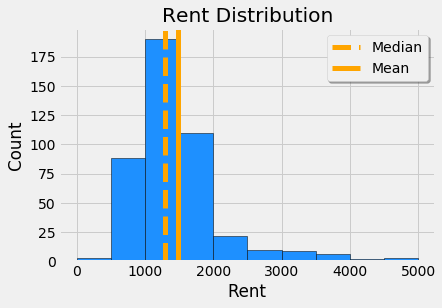

In [9]:
#Exploratory Analysis
plt.style.use('fivethirtyeight')
plt.xlabel('Rent')
plt.ylabel('Count')
plt.title('Rent Distribution')

plt.hist(df['Prices'],bins = range(0,5500,500),edgecolor = 'black',color = 'dodgerblue')
plt.axvline(stats.median(df['Prices']),color = 'orange',linewidth = 5,linestyle = '--',label = 'Median')
plt.axvline(stats.mean(df['Prices']),color = 'orange',linewidth = 5,linestyle = '-',label = 'Mean')
plt.legend(loc = 'best',shadow = True)

Text(0.5, 1.0, 'Baths Distribution')

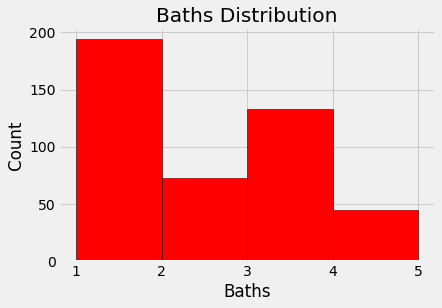

In [10]:
plt.hist(df['Baths'],bins = range(1,6,1),edgecolor = 'black',color = 'red')
plt.xlabel('Baths')
plt.ylabel('Count')
plt.title('Baths Distribution')

Text(0.5, 1.0, 'Baths Scatter Plot')

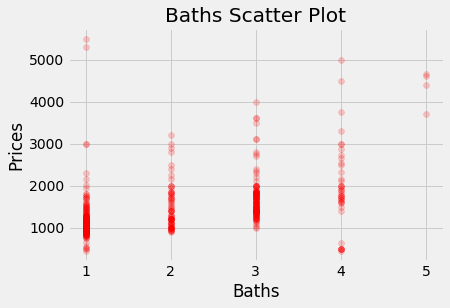

In [11]:
plt.scatter(df['Baths'],df['Prices'],color = 'r',alpha = .2)
plt.xlabel('Baths')
plt.ylabel('Prices')
plt.title('Baths Scatter Plot')

Text(0.5, 1.0, 'Beds Distribution')

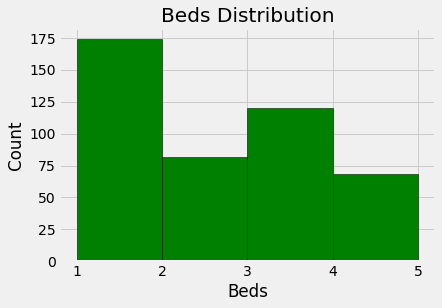

In [12]:
plt.hist(df['Beds'],bins = range(1,6,1),color = 'g',edgecolor = 'k')
plt.xlabel('Beds')
plt.ylabel('Count')
plt.title('Beds Distribution')

Text(0.5, 1.0, 'Beds Scatter Plot')

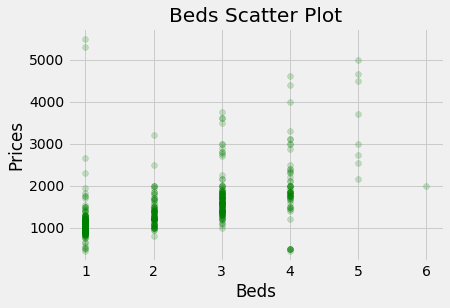

In [13]:
plt.scatter(df['Beds'],df['Prices'],color = 'g',alpha = .2)
plt.xlabel('Beds')
plt.ylabel('Prices')
plt.title('Beds Scatter Plot')

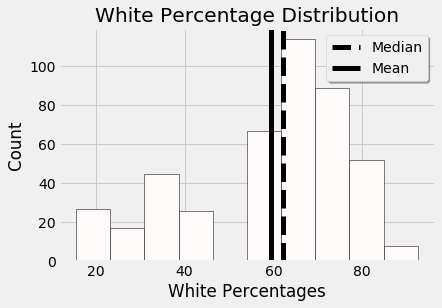

In [14]:
plt.hist(df['White'],color = 'snow',edgecolor = 'k')
plt.xlabel('White Percentages')
plt.ylabel('Count')
plt.title('White Percentage Distribution')
plt.axvline(stats.median(df['White']),color = 'k',linewidth = 5,linestyle = '--',label = 'Median')
plt.axvline(stats.mean(df['White']),color = 'k',linewidth = 5,linestyle = '-',label = 'Mean')
plt.legend(loc = 'best',shadow = True)

Text(0.5, 1.0, 'White Percentages Scatter Plot')

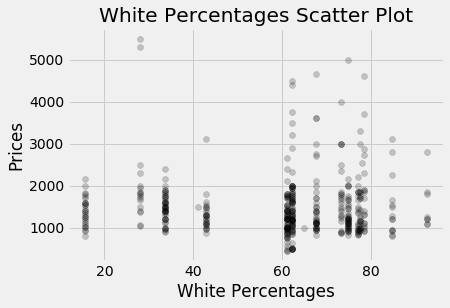

In [15]:
plt.scatter(df['White'],df['Prices'],color = 'k',alpha = .2)
plt.xlabel('White Percentages')
plt.ylabel('Prices')
plt.title('White Percentages Scatter Plot')

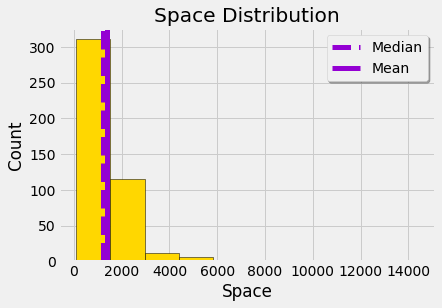

In [16]:
plt.hist(df['Space(sqft)'],color = 'gold',edgecolor = 'k')
plt.xlabel('Space')
plt.ylabel('Count')
plt.title('Space Distribution')
plt.axvline(stats.median(df['Space(sqft)']),color = 'darkviolet',linewidth = 5,linestyle = '--',label = 'Median')
plt.axvline(stats.mean(df['Space(sqft)']),color = 'darkviolet',linewidth = 5,linestyle = '-',label = 'Mean')
plt.legend(loc = 'best',shadow = True)

Text(0.5, 1.0, 'Space Scatter Plot')

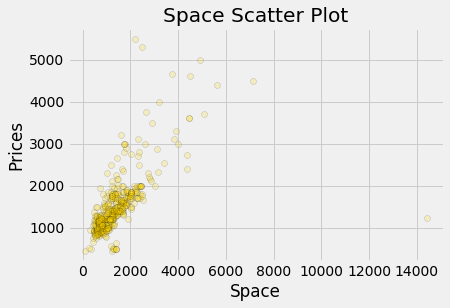

In [17]:
plt.scatter(df['Space(sqft)'],df['Prices'],color = 'gold',alpha = .2,edgecolor = 'k')
plt.xlabel('Space')
plt.ylabel('Prices')
plt.title('Space Scatter Plot')

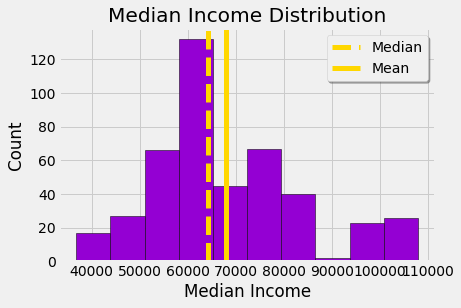

In [18]:
plt.hist(df['Median_Income'],color = 'darkviolet',edgecolor = 'k')
plt.xlabel('Median Income')
plt.ylabel('Count')
plt.title('Median Income Distribution')
plt.axvline(stats.median(df['Median_Income']),color = 'gold',linewidth = 5,linestyle = '--',label = 'Median')
plt.axvline(stats.mean(df['Median_Income']),color = 'gold',linewidth = 5,linestyle = '-',label = 'Mean')
plt.legend(loc = 'best',shadow = True)

Text(0.5, 1.0, 'Median Income Plot')

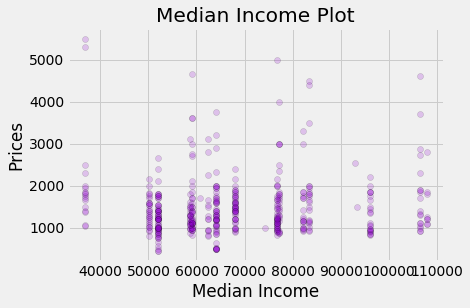

In [19]:
plt.scatter(df['Median_Income'],df['Prices'],color = 'darkviolet',alpha = .2,edgecolor = 'k')
plt.xlabel('Median Income')
plt.ylabel('Prices')
plt.title('Median Income Plot')

In [21]:
##Multivariate Regression
regression = linear_model.LinearRegression()
regression.fit(df[['Baths','Beds','Space(sqft)','Median_Income','White']],df['Prices'])

print('The R^2 of the full Multivariate Model is: ',regression.score(df[['Baths','Beds','Space(sqft)','Median_Income','White']],df['Prices']))
print('The Intercept of the full model is: ',regression.intercept_)

predictions = []
residuals = []
for i in range(0,len(list(df['Beds'])),1):
    prediction = regression.predict(np.array([[list(df['Baths'])[i],list(df['Beds'])[i],list(df['Space(sqft)'])[i],list(df['Median_Income'])[i],list(df['White'])[i]]]))
    predictions.append(prediction)
    residuals.append(list(df['Prices'])[i] - prediction[0])


The R^2 of the full Multivariate Model is:  0.4410961041629793
The Intercept of the full model is:  598.5921374004541


Text(0, 0.5, 'Residuals')

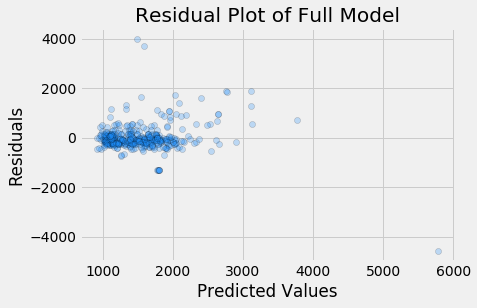

In [22]:
#Residual Plots for full fitted model
plt.scatter(predictions,residuals,alpha = .25,color = 'dodgerblue',edgecolor = 'k')
plt.title('Residual Plot of Full Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

In [23]:
#Prints the p-values to do backwards selection on
scores, pvalues = chi2(df[['Baths','Beds','Space(sqft)','Median_Income','White']],df['Prices'])
predictors = df[['Baths','Beds','Space(sqft)','Median_Income','White']]

pvalues = list(pvalues)
pvalues = [float(i) for i in pvalues]

#This is for backwards selection using p-value of .05
count = 0
for i in range(0,len(pvalues),1):
    maxPvalue = max(pvalues)
    if(maxPvalue >= .05):
        predictors.drop(predictors.columns[pvalues.index(maxPvalue)],axis = 1,inplace = True)
        
        reg = linear_model.LinearRegression()
        reg.fit(predictors,df['Prices'])
        
        scores, pvalues = chi2(predictors,df['Prices'])
        pvalues = list(pvalues)
        pvalues = [float(i) for i in pvalues]
        
    else:
        pass
        
        

    count += 1



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [24]:
#Final Predictor variables used for final regression
print(predictors.head(5))

   Space(sqft)  Median_Income  White
2         4379         106469   78.4
3         1568          83309   62.2
4          677          58983   67.7
5          640          96185   77.0
6          695          77092   73.3


In [25]:
#Final Predictor Variables in final regression
print(pvalues)

[0.0, 0.0, 4.674945525656741e-138]


In [26]:
print('The R^2 of the full Multivariate Model is: ',reg.score(predictors,df['Prices']))

The R^2 of the full Multivariate Model is:  0.39449321908458146
